**Libraries imported and used in this Assessment:**<br><br>
***os*** - For reading the data files from the machine,<br>
***pandas,numpy, matplotlib, seaborn and collections*** - For converting the text files read into dataframes, manipulating them, analysing and visualising them,<br>
***sklearn*** - For text feature_extraction, building machine learning models, validating and analysing those models,<br>
***nltk*** - natural language processing toolkit for performing text tokenisation, stop words removal and lemmatization <br>

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import resample
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import contractions
import collections
from wordcloud import WordCloud,STOPWORDS
#additional stop words
from spacy.lang.en.stop_words import STOP_WORDS

# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
# nltk.download("wordnet")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.metrics import classification_report

#For printing the values without calling print() function everytime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Setting k=10 for 10 fold cross validation
strat_kFold=StratifiedKFold(10,True,599)

In [ ]:
# !pip install contractions
# !pip install wordcloud
# !pip install imbalanced-learn
# !pip install spacy

In [3]:
music_df=pd.read_json("Musical_Instruments.json", lines=True)

In [4]:
music_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [5]:
len(music_df)

10261

**900 unique products in musical instruments**

In [6]:
len(music_df.asin.unique())

900

**1429 unique users have purchased products related to musical instruments**

In [7]:
len(music_df.reviewerID.unique())

1429

**Identifier Attributes and Irrelevant Attributes**

ReviewerID and asin(Product_id) are ID attributes and reviewerName, reviewedTime are the other attributes that are dropped from feature space.

In [8]:
music_df.drop(['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime'], axis=1, inplace=True)

In [9]:
music_df.head()

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5,good
1,The product does exactly as it should and is q...,5,Jake
2,The primary job of this device is to block the...,5,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.


In [10]:
music_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  10261 non-null  object
 1   overall     10261 non-null  int64 
 2   summary     10261 non-null  object
dtypes: int64(1), object(2)
memory usage: 240.6+ KB


**Review Text and Summary text** are concatanated into a **new column** called **Review** since they both contain reviews. The old columns are dropped then.

In [11]:
music_df['review']=music_df['reviewText']+music_df['summary']

In [12]:
music_df.drop(['reviewText','summary'],axis=1,inplace=True)

In [13]:
music_df.head()

,overall,review
0,5,"Not much to write about here, but it does exac..."
1,5,The product does exactly as it should and is q...
2,5,The primary job of this device is to block the...
3,5,Nice windscreen protects my MXL mic and preven...
4,5,This pop filter is great. It looks and perform...


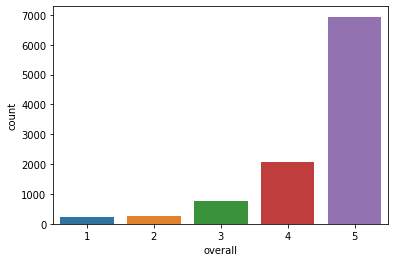

In [14]:
sns.countplot('overall',data=music_df)

**The dataset is heavily skewed as higher ratings (4 & 5 stars) have more records while poor ratings (1, 2, and 3) have very less data**

So, going by the intuition, a new target label **product_rating_class** is created with two categories (1 for the products having rating more than 3) and 0 for the products having rating less than or equal to 3). Then the overall attribute is dropped.

In [15]:
music_df['product_rating_class']= np.where(music_df['overall']>3,1,0)

In [16]:
music_df.drop(['overall'],axis=1,inplace=True)

In [17]:
music_df.head()

,review,product_rating_class
0,"Not much to write about here, but it does exac...",1
1,The product does exactly as it should and is q...,1
2,The primary job of this device is to block the...,1
3,Nice windscreen protects my MXL mic and preven...,1
4,This pop filter is great. It looks and perform...,1


In [18]:
music_df['product_rating_class'].value_counts()

1    9022
0    1239
Name: product_rating_class, dtype: int64

Even after grouping the reviews into good(1) and bad(0) categories, we still face the data imbalance problem which needs to be dealt with in the preprocessing or modelling sections

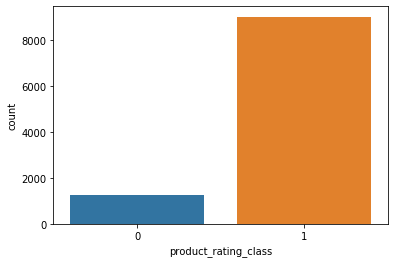

In [19]:
sns.countplot('product_rating_class',data=music_df)

In [20]:
#List of special characters to be removed
splChars=["?",":",";",",","(",")",".","'","-","_","|","/",">","<","\"","=","!","&","@","$","#","%","*","[","]","'s","n't","``","..."]
#Set of stop words in english language obtained from nltk corpus
stop_words = set(stopwords.words('english'))

**Text Cleaning**

This project falls under **Natural Language Processing** binary text classification problem (2 classes). So, for the Machine Learning classification models to perform better on these tasks, the text should be cleaned. The following cleaning strategies has been implemented.

&nbsp;&nbsp;1) **Tokenization** - This is the process of splitting longer texts into smaller pieces which would be helpful in further cleaning of the texts. Here, the entire reviewText is tokenized into individual words.<br><br>
&nbsp;&nbsp;2) Converted all the text into lower case <br> &nbsp;&nbsp;&nbsp;&nbsp; 3) **Removed Punctuations and other Special Characters** <br> &nbsp;&nbsp;&nbsp;&nbsp; 4) Removed the numbers as they don't carry quality information <br> &nbsp;&nbsp;&nbsp;&nbsp; 5) **Removed the Stop words** - The set of common words in the text which do not convey any useful information for classification purposes) <br> &nbsp;&nbsp;&nbsp;&nbsp; 6) **Lemmatization** is done - The process of converting a word to its canonical base form using its lemma (Ex: best -> good).

In [21]:
#Function to clean the text data 
def cleanTextData(df):
    
    #Convert the entire text into lower case
    df['review']=df.apply(lambda row: row['review'].lower(),axis=1)

    #Tokenize each sentence into an array of words
    df['review']=df.apply(lambda row:nltk.word_tokenize(row['review']),axis=1)
    
    #Expand the contractions in each product review
    df['review']=df.apply(lambda row:([contractions.fix(word) for word in row['review']]),axis=1)

    #Removing the special characters, stop words and any numbers from the array of words
    df['review']=df.apply(lambda row:([word for word in row['review'] if word not in splChars and word not in STOP_WORDS and not word.isdigit()]),axis=1)

    #Lemmatizer object instantiation
    lemmatizer = WordNetLemmatizer()

    #Convert each word in the array in the dataframe to its base word using NLTK Lemmatizer
    df['review']=df.apply(lambda row:([lemmatizer.lemmatize(word,pos="v") for word in row['review']]),axis=1)
    
    #Join the array of words in each row of the dataframes into a string
    df['review']=[" ".join(review) for review in df['review'].values]
    
    #Return the cleaned text data
    return df


In [23]:
music_df_cleaned=cleanTextData(music_df)

In [24]:
music_df_cleaned.head()

,review,product_rating_class
0,write exactly suppose filter pop sound record ...,1
1,product exactly affordable.i realize double sc...,1
2,primary job device block breath produce pop so...,1
3,nice windscreen protect mxl mic prevent pop th...,1
4,pop filter great look perform like studio filt...,1


In [25]:
#function to find the most frequently used words in good and bad rating class
def frequentWords(df,isGood, numberOfCommon):
    
    filtered_words=[]
    
    #Concatenate the text in each row of the dataframe into a single string or sentence based on its target class
    if isGood:
        msgs=' '.join(df[df['product_rating_class']==1]['review'])
    else:
        msgs=' '.join(df[df['product_rating_class']==0]['review'])

    filtered_words=msgs.split()
    
    #Count the number of times each word appeared in the data set
    words_count=collections.Counter(filtered_words)

    words=[]
    counts=[]

    #Retrieve the top n frequently used words from the word_count collection and return the word and count array as a tuple
    for word,count in words_count.most_common(numberOfCommon):
        words.append(word)
        counts.append(count)
        print(word,":",count)
    return(words,counts)

In [26]:
#Top 10 Frequent words in Good rating class
(words,counts)=frequentWords(music_df_cleaned,1,numberOfCommon=10)

guitar : 5177
sound : 4651
string : 4458
great : 4436
like : 3644
good : 3642
use : 3451
pedal : 3382
work : 3299
play : 2567


Text(0.5, 1.0, 'Top 10 most frequently used words in Good rating products')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Words')

<BarContainer object of 10 artists>

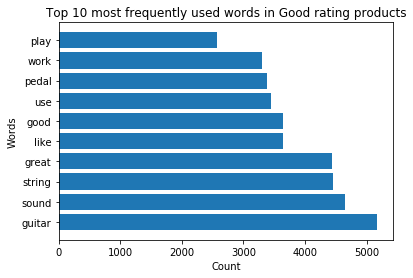

In [27]:
#Bar plot configs
# rcParams['figure.figsize']=9,9
plt.title("Top 10 most frequently used words in Good rating products")
plt.xlabel("Count")
plt.ylabel("Words")
plt.barh(words,counts)

In [28]:
good = music_df_cleaned[music_df_cleaned['product_rating_class']== 1]['review']
bad = music_df_cleaned[music_df_cleaned['product_rating_class']== 0]['review']

<Figure size 1440x1440 with 0 Axes>

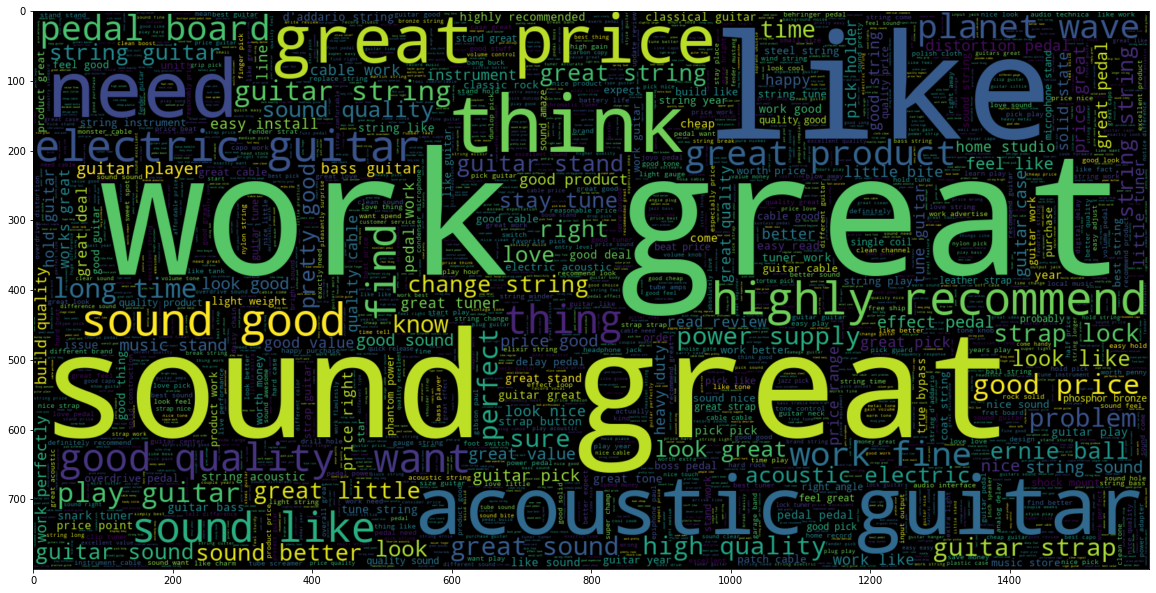

In [29]:
plt.figure(figsize = (20,20))
#create the wordcloud object
wordcloud = WordCloud(stopwords=STOP_WORDS,collocations=True,min_word_length=4,collocation_threshold=3,min_font_size=3,max_words=3000,width=1600,height=800).generate(" ".join(good))
plt.imshow(wordcloud,interpolation = 'bilinear')

In [30]:
word_freq={k: v for k, v in sorted(wordcloud.process_text(" ".join(good)).items(),reverse=True, key=lambda item: item[1])}

#Relative Frequency
rel_freq=wordcloud.words_

In [31]:
print(list(word_freq.items())[:5])
print(list(rel_freq.items())[:5])

[('work great', 605), ('sound great', 436), ('like', 428), ('acoustic guitar', 388), ('need', 377)]
[('work great', 1.0), ('sound great', 0.7206611570247934), ('like', 0.7074380165289256), ('acoustic guitar', 0.6413223140495867), ('need', 0.6231404958677685)]


<Figure size 1440x1440 with 0 Axes>

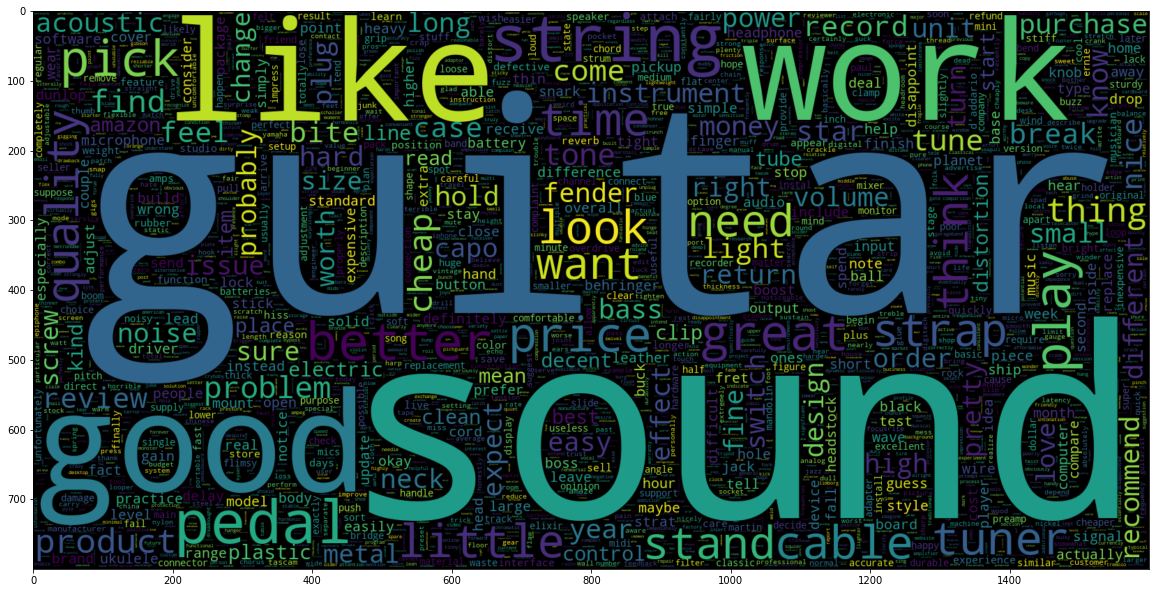

In [35]:
plt.figure(figsize = (20,20))
#create the wordcloud object
wordcloud = WordCloud(stopwords=STOP_WORDS,collocations=False, min_word_length=4,min_font_size=3,max_words=3000,width=1600,height=800).generate(" ".join(bad))
plt.imshow(wordcloud,interpolation = 'bilinear')

In [36]:
word_freq={k: v for k, v in sorted(wordcloud.process_text(" ".join(bad)).items(),reverse=True, key=lambda item: item[1])}

rel_freq=wordcloud.words_

In [37]:
print(list(word_freq.items())[:10])
print(list(rel_freq.items())[:10])

[('guitar', 849), ('sound', 685), ('good', 617), ('like', 615), ('work', 604), ('string', 596), ('pedal', 477), ('better', 362), ('play', 342), ('great', 324)]
[('guitar', 1.0), ('sound', 0.806831566548881), ('good', 0.7267373380447585), ('like', 0.7243816254416962), ('work', 0.7114252061248527), ('string', 0.702002355712603), ('pedal', 0.5618374558303887), ('better', 0.42638398115429915), ('play', 0.4028268551236749), ('great', 0.38162544169611307)]


In [38]:
#Boxplot to analyse the distribution of good and bad reviews
music_df_cleaned['ReviewLength']=music_df_cleaned.apply(lambda row: len(row['review'].split()),axis=1)

**Reviews for poorly rated products tends to have more length in average. This could be attributed to the customers expressing their dissatisfaction on the products**

ReviewLength                                         \
                            count       mean        std  min   25%   50%   
product_rating_class                                                       
0                          1239.0  48.161421  59.211633  3.0  18.0  30.0   
1                          9022.0  40.516183  49.047259  1.0  15.0  25.0   

                                    
                       75%     max  
product_rating_class                
0                     55.0   776.0  
1                     45.0  1021.0

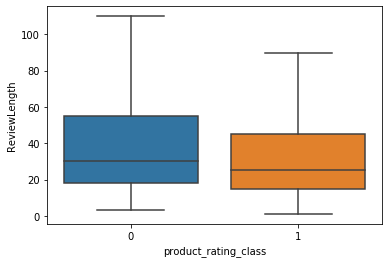

In [39]:
#Analyse and visualise the length of the reviews in both good and bad class in training set 
music_df_cleaned.groupby('product_rating_class').describe()
sns.boxplot(x='product_rating_class',y='ReviewLength', data=music_df_cleaned, showfliers=False)
plt.show()

In [40]:
music_df_cleaned.drop("ReviewLength", axis=1, inplace=True)

**Stratified Train/Test Split - 70:30 ratio is taken** 

Stratified split is used to maintain the distribution of majority and minority class across the training and testing set. This will give us a simulation of the distribution of real time unseen data.

In [41]:
train_df, test_df =train_test_split(music_df_cleaned,test_size=0.3,random_state=599,stratify=music_df_cleaned['product_rating_class'])

In [42]:
train_df['product_rating_class'].value_counts()/len(train_df)

1    0.879282
0    0.120718
Name: product_rating_class, dtype: float64

In [43]:
test_df['product_rating_class'].value_counts()/len(test_df)

1    0.879182
0    0.120818
Name: product_rating_class, dtype: float64

In [44]:
np.bincount(test_df['product_rating_class'])

array([ 372, 2707], dtype=int64)

In [45]:
#Training set Reviews
x_train=train_df['review']
#Training Labels
y_train=train_df['product_rating_class']

#Testing set Reviews
x_test=test_df['review']
#Testing Labels
y_test=test_df['product_rating_class']

**Feature Extraction**

Note: The numerical features were extracted from both the training and testing set reviews. The training set reviews were fitted and transformed using Tf-Idf Vectorizer while the testing set reviews were transformed using the fitted Tf-Idf vectorizer.

Machine Learning models can **only deal with the numbers as the features**. As we had text data with us, it was necessary to **convert the text into numerical features**. We can't simply convert the text into its basic numeric form as that won't possess any meaning at all. It should be **vectorized** in such a way that it provides **some useful information.**This could be done by the process called **Vectorization in NLP** i.e., converting the words into vectors.<br><br>There are two ways to vectorize using either **CountVectorizer or Tf-Idf Vectorizer**. We have taken **Tf-Idf Vectorizer here**. Tf-Idf (Term Frequency-Inverse Document Frequency) where **Term Frequency** represents the **importance of a word local to a document by finding how frequently it occured in a specific document** whereas **Inverse Document Frequency** represents the **importance of a word in a document by finding how often it appeared across all the other documents**. **Tf-Idf** is the **product of the above two frequencies** i.e., for a word to have **high tf-idf score** in a document, it should **appear a lot of times in that document** and should **be absent or appeared very less times in other documents**. 

In [57]:
from sklearn.pipeline import make_pipeline

for n_estimators in range(10,60,10):
    random_forest_clf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=n_estimators, class_weight={0:5,1:0.2}, random_state=599))
    scores_wt = cross_validate(random_forest_clf, train_df['review'], train_df['product_rating_class'], scoring=['precision','f1'], return_train_score=False)
    print("Number of Trees in Random Forest: ", n_estimators)
    print("Test_Precision: ",scores_wt['test_precision'].mean())
    print("Test F1: ",scores_wt['test_f1'].mean())

Number of Trees in Random Forest:  10
Test_Precision:  0.894879779083829
Test F1:  0.9311738089074171
Number of Trees in Random Forest:  20
Test_Precision:  0.890089669118532
Test F1:  0.93447778821409
Number of Trees in Random Forest:  30
Test_Precision:  0.887833424872154
Test F1:  0.9356509260819464
Number of Trees in Random Forest:  40
Test_Precision:  0.8884366292012629
Test F1:  0.9369753277494282
Number of Trees in Random Forest:  50
Test_Precision:  0.8877596082493102
Test F1:  0.9363869171526703


**The hyperparameter-number of trees is tuned** and the optimal precision is obtained with 10 trees. The configuration is selected and trained with full training set.

In [58]:
random_forest_clf_full = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=10, class_weight={0:5,1:0.2}, random_state=599))

In [59]:
random_forest_clf_full.fit(x_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 5, 1: 0.2},
                                        n_estimators=10, random_state=599))])

In [100]:
def displayMetrics(classifier, x_test, y_test):
    
    pred=classifier.predict(x_test)
    print("F1 Score: ",metrics.f1_score(y_test,pred))
    print("Precision Score: ",metrics.precision_score(y_test,pred))
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred).ravel()
    print("TN: ",tn,"FP: ",fp,"FN: ",fn,"TP: ",tp)


In [101]:
displayMetrics(random_forest_clf_full,x_test, y_test)

F1 Score:  0.933972310969116
Precision Score:  0.8988725657669969
TN:  76 FP:  296 FN:  76 TP:  2631


In [67]:
#Multinomial Naive Bayes Classifier Object with its default parameters
multinomial_NB=MultinomialNB()

multinomial_nb_clf = make_pipeline(TfidfVectorizer(), multinomial_NB)
scores_nb = cross_validate(multinomial_nb_clf, train_df['review'], train_df['product_rating_class'], scoring=['precision','f1'], cv=strat_kFold, return_train_score=False)
print("Test_Precision: ",scores_nb['test_precision'].mean())
print("Test F1: ",scores_nb['test_f1'].mean())

Test_Precision:  0.8792816159863011
Test F1:  0.9357634320299276


In [69]:
#Laplace Smoothing Parameter for Multinomial Naive Bayes model 
alpha=[1,0.1,0.01]

multinomial_NB=MultinomialNB()
multinomialNB_hyperparams=dict(alpha=alpha)

multinomialNB_clf_tuning=GridSearchCV(multinomial_NB,multinomialNB_hyperparams,cv=10,verbose=0)

vectorizer=TfidfVectorizer()

vectorized_x_train=vectorizer.fit_transform(train_df['review'])
vectorized_x_test=vectorizer.transform(test_df['review'])

best_multinomialNB_model=multinomialNB_clf_tuning.fit(vectorized_x_train, train_df['product_rating_class'])

#Optimal value for the Parameters
best_multinomialNB_model.best_estimator_

MultinomialNB(alpha=1)

In [76]:
displayMetrics(best_multinomialNB_model.best_estimator_,x_test, y_test)

F1 Score:  0.933972310969116
Precision Score:  0.8988725657669969
TN:  76 FP:  296 FN:  76 TP:  2631


In [97]:
scores=[]

#Cross validating with Stratified 10 fold
for fold, (train_index, test_index) in enumerate(strat_kFold.split(x_train,y_train), 1):
    
    X_train_fold = x_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = x_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    #Preprocessing by converting text to numeric features using TFIDF Vectorizer
    vectorizer=TfidfVectorizer()
    vectorized_x_train_fold=vectorizer.fit_transform(X_train_fold)
    vectorized_x_test_fold=vectorizer.transform(X_test_fold)
    
    #SMOTE oversampling is done for each iteration in kfold to avoid possible data leakage which could result in over optimistic results 
    sm = SMOTE(random_state=599)
    X_train_oversampled, y_train_oversampled = sm.fit_resample(vectorized_x_train_fold, y_train_fold)
    model = MultinomialNB()
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(vectorized_x_test_fold)
    print(f'For fold {fold}:')
    print(f'Precision-score: {metrics.precision_score(y_test_fold, y_pred)}')
    scores.append(metrics.precision_score(y_test_fold, y_pred))

print("The mean Precision Score from the 10 Fold stratified CV is: ", sum(scores)/len(scores))

MultinomialNB()

For fold 1:
Precision-score: 0.9550359712230215


MultinomialNB()

For fold 2:
Precision-score: 0.9659735349716446


MultinomialNB()

For fold 3:
Precision-score: 0.950354609929078


MultinomialNB()

For fold 4:
Precision-score: 0.9499072356215214


MultinomialNB()

For fold 5:
Precision-score: 0.94


MultinomialNB()

For fold 6:
Precision-score: 0.9472727272727273


MultinomialNB()

For fold 7:
Precision-score: 0.943609022556391


MultinomialNB()

For fold 8:
Precision-score: 0.9408502772643254


MultinomialNB()

For fold 9:
Precision-score: 0.9422382671480144


MultinomialNB()

For fold 10:
Precision-score: 0.9500891265597148
The mean Precision Score from the 10 Fold stratified CV is:  0.9485330772546436


**The SMOTE Oversampling with 10 fold stratified CV gives a performance boost for the Multinomial Naive Bayes model in predicting the minority class which is of interest to us. Let us evaluate the model with the unseen test set to verify the cross validated results are not over optimistic** 

In [105]:
vectorizer=TfidfVectorizer()
vectorized_x_train=vectorizer.fit_transform(x_train)
vectorized_x_test=vectorizer.transform(x_test)
    
sm = SMOTE(random_state=599)
X_train_oversampled, y_train_oversampled = sm.fit_resample(vectorized_x_train, y_train)
model = MultinomialNB()
model.fit(X_train_oversampled, y_train_oversampled )  
y_pred = model.predict(vectorized_x_test)
print(f'Precision-score: {metrics.precision_score(y_test, y_pred)}')

MultinomialNB()

Precision-score: 0.9456993918331885


In [106]:
displayMetrics(model,vectorized_x_test,y_test)

F1 Score:  0.8692353763226193
Precision Score:  0.9456993918331885
TN:  247 FP:  125 FN:  530 TP:  2177


**The test set evaluation results for Multinomial NB with oversampling of minority class with SMOTE wins over the other models we have tried. The precision has increased from 0.89 to 0.94 with the the false positives reducing from 296 to 125. This has happened at the cost of increase in false negatives. But our goal is to mainly focus on reducing the misclassification of minority class. The possible next steps in further improving the performance could be trying boosting algorithms and deep neural networks like RNN**